# S2VSR 2023-06

The PyrNet setup for [Small Scale Variability of Solar Radiation (S2VSR)](https://www.arm.gov/research/campaigns/sgp2023s2vsr) was setup for calibration on the ARM-SGP guest instrument facility (**GIF**) for calibration from 2023-06-02 to 2023-06-08. Cross-calibration is done versus reference observations from the ARM-SGP broadband radiometer station (**BRS**) ([doi:10.5439/1550918](http://dx.doi.org/10.5439/1550918))

![ARM-SGP layout map](https://www.arm.gov/uploads/SGP_Instrument_Map.png)


## Imports

In [1]:
#|dropcode
import os
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import jstyleson as json

from pyrnet import pyrnet

## Prepare PyrNet data
For calibration preparation the PyrNet data is processed to level l1b using a calibration factor of **7 (uV W-1 m2)** for all pyranometers with the ```pyrnet process l1b``` tool. This is done to unify the conversion to sensor voltage during calibration and not run into valid_range limits for netcdf encoding. Here we generate the *calibration.json* file for the processing to l1b:   

In [2]:
box_numbers = np.arange(1,101)
calibrations = {f"{bn:03d}":[7,7] for bn in box_numbers}
calibjson = {"2000-01-01": calibrations}
# with open("pyrnet_calib_prep.json","w") as txt:
#     json.dump(calibjson, txt)

Within *pyrnet_config_calibration_prep.json*:
```
{"file_calibration" : "pyrnet_calib_prep.json"}
```

**Workflow for preparation**
1. Prepare *pyrnet_config_calibration_prep.json* with contributors metadata and the dummy calibration config file.
1. ```$ pyrnet process l1a -c pyrnet_config_calibration_prep.json raw_data/*.bin l1a/```
1. ```$ pyrnet process l1b -c pyrnet_config_calibration_prep.json l1a/*.nc l1b/```
1. ```$ d=2023-06-02; until [[ $d > 2023-06-08 ]]; do pyrnet merge l1b/pyrnet_${d}_*.nc l1b_network/pyrnet_${d}_s2vsr_calibration.c01.nc; d=$(date -I -d "$d + 1 day"); done```
1. Upload the network files to the Thredds server

## Configuration
Data is available via Thredds server. The URLs might have changed when trying to rerun this notebook. 

For the ARM data, create a ARM user account first and then order the [doi:10.5439/1550918](http://dx.doi.org/10.5439/1550918), and choose the Thredds-Server option. You will receive the Thredds-URL via e-mail.

The PyrNet data should be available via [tds.tropops.de](tds.tropos.de), if not, contact witthuhn@tropos.de.


In [3]:
ARM_URL = "https://archive.arm.gov/orders/dodsC/orders/witthuhnj1/240295/sgpbrsC1.b1.{date:%Y%m%d}.000000.custom.cdf"
PYR_URL = "https://tds.tropos.de/thredds/dodsC/scccJher/2023_s2vsr/calibration/pyrnet_{date:%Y-%m-%d}_s2vsr_calibration.c01.nc"
dates = pd.date_range("2023-06-02","2023-06-08")
stations = np.arange(1,101)

# lookup which box contains actually a pyranometer/ extra pyranometer
mainmask, extramask = [] , []
for box in stations:
    _, serials, _ = pyrnet.meta_lookup(dates[0],box=box)
    mainmask.append( True if len(serials[0])>0 else False )
    extramask.append( True if len(serials[1])>0 else False )

### Load ARM-SGP Data

In [4]:
#|dropcode
#|dropout
for i,date in enumerate(dates):
    # read from thredds server
    dst = xr.open_dataset(ARM_URL.format(date=date))
    
    # drop not needed variables
    keep_vars = ['down_short_hemisp']
    drop_vars = [v for v in dst if v not in keep_vars]
    dst = dst.drop_vars(drop_vars)
    
    # merge
    if i == 0:
        ds = dst.copy()
    else:
        ds = xr.concat((ds,dst),dim='time', data_vars='minimal', coords='minimal', compat='override')

arm = ds.copy()
arm

<xarray.Dataset>
Dimensions:            (time: 10080)
Coordinates:
  * time               (time) datetime64[ns] 2023-06-02 ... 2023-06-08T23:59:00
Data variables:
    down_short_hemisp  (time) float32 7.642 6.241 5.941 ... 165.9 165.4 170.4
Attributes: (12/26)
    command_line:                    sirs_ingest -n brs -s sgp -f C1
    Conventions:                     ARM-1.3
    process_version:                 ingest-sirs-12.9-0.el7
    dod_version:                     brs-b1-4.0
    input_source:                    /data/collection/sgp/sgpbrsC1.00/BRS_Tab...
    site_id:                         sgp
    ...                              ...
    lithium_battery:                 3.37
    low_12v_count:                   4872.0
    skipped_scan:                    0.0
    doi:                             10.5439/1550918
    history:                         created by user dsmgr on machine prod-pr...
    DODS_EXTRA.Unlimited_Dimension:  time

### Load PyrNet Data

In [5]:
#|dropcode
#|dropout
for i,date in enumerate(dates):
    # read from thredds server
    dst = xr.open_dataset(PYR_URL.format(date=date))
    
    # drop not needed variables
    keep_vars = ['ghi','gti','szen']
    drop_vars = [v for v in dst if v not in keep_vars]
    dst = dst.drop_vars(drop_vars)

    # unify time and station dimension to speed up merging
    date = dst.time.values[0].astype("datetime64[D]")
    timeidx = pd.date_range(date, date + np.timedelta64(1, 'D'), freq='1s', inclusive='left')
    dst = dst.interp(time=timeidx)
    dst = dst.reindex({"station": stations})
    
    # add gti for single stations
    if "gti" not in dst:
        dst = ds.assign({
            "gti": (("time","station"), np.full(dst.ghi.values.shape,np.nan))
        })
    
    # merge
    if i == 0:
        ds = dst.copy()
    else:
        ds = xr.concat((ds,dst),dim='time', data_vars='minimal', coords='minimal', compat='override')
    
pyr = ds.copy()
pyr

<xarray.Dataset>
Dimensions:  (station: 100, time: 604800)
Coordinates:
  * station  (station) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 2023-06-02 ... 2023-06-08T23:59:59
Data variables:
    ghi      (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    gti      (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    szen     (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        -97.48579382293494
    geospatial_lon_units:      degE
    time_coverage_start:       2023-06-02T17:38:35
    time_coverage_end:         2023-06-02T23:59:59
    time_coverage_duration:    P0DT6H21M24S
    time_coverage_resolution:  P0DT0H0M1S

## Calibration
The calibration follows the [ISO 9847:1992 - Solar energy — Calibration of field pyranometers by comparison to a reference pyranometer](https://archive.org/details/gov.in.is.iso.9847.1992).
> TODO: Revise versus 2023 EU version.

Cloudy sky treatment is applied.

### Step 1
Drop Night measures and low signal measures from pyranometer data. Since calibration without incoming radiation doesnt work.

This data is kept for calibration:

 * solar zenith angle < 80° ( as recommended in ISO 9847)
 * Measured Voltage > 0.033 V, e.g. ADC count is 0 or 1 of 1023 (drop the lowest ~1%)
 
Voltage measured ($V_m$) at the logger is the amplified Senor voltage ($V_S$) by a gain of 300.

$ V_m = 300 V_S$

As the uncalibrated flux measurements ($F_U$) are calibrated with a fixed factor of 7 uV W-1 m2:

$ V_s = 7*1e-6* F_U $

In [6]:
# Set flux values to nan if no pyranometer is installed.
pyr.ghi.values = pyr.ghi.where(mainmask).values
pyr.gti.values = pyr.gti.where(extramask).values

# convert to measured voltage
pyr.ghi.values = pyr.ghi.values * 7 * 1e-6
pyr.gti.values = pyr.gti.values * 7 * 1e-6

# Step 1, select data
pyr = pyr.where(pyr.szen<80, drop=True)
pyr.ghi.values = pyr.ghi.where(pyr.ghi>0.033/300.).values
pyr.gti.values = pyr.gti.where(pyr.gti>0.033/300.).values

### Step 2
Interpolate reference to PyrNet samples and combine to a single Dataset

In [7]:
# interpolate reference to PyrNet
arm = arm.interp(time=pyr.time)

# Calibration datasets for main and extra pyranometer
Cds_main = xr.Dataset(
    data_vars={
        'reference_Wm2': ('time', arm['down_short_hemisp'].data),
        'pyrnet_V': (('time','station'), pyr['ghi'].data)
    },
    coords= {
        "time": pyr.time,
        "station": pyr.station
    }
)

Cds_extra = xr.Dataset(
    data_vars={
        'reference_Wm2': ('time', arm['down_short_hemisp'].data),
        'pyrnet_V': (('time','station'), pyr['gti'].data)
    },
    coords= {
        "time": pyr.time,
        "station": pyr.station
    }
)

### Step 3
Remove outliers from series using xarray grouping and apply function. The following functions removes outliers (deviation more than 2% according to ISO 9847) from a selected group. This step involves calculating calibration series and the integration of one hour intervals to smooth out high variable situation, which would break the calibration even when time synchronization is slightly off. Also this gets rid of some random shading events like birds / chimney / rods in line of sigth, which would affect calibration otherwise. We following ISO 9847 5.4.1.1 equation (2) here.

In [8]:
def remove_outliers(x):
    """
    x is an xarray dataset containing these variables:
    coords: 'time' - datetime64
    'pyrnet_V' - array - voltage measures of pyranometer
    'reference_Wm2' - array - measured irradiance of reference
    """

    # calculate calibration series for single samples
    C = x['pyrnet_V'] / x['reference_Wm2']
    # integrated series 
    ix = x.integrate('time')
    M = ix['pyrnet_V'] / ix['reference_Wm2']
    
    while np.any(np.abs(C-M) > 0.02*M):
        #calculate as long there are outliers deviating more than 2 percent
        x = x.where(np.abs(C-M) < 0.02*M)
        C = x['pyrnet_V'] / x['reference_Wm2']
        #integrated series 
        ix = x.integrate('time')
        M = ix['pyrnet_V'] / ix['reference_Wm2']
        
    #return the reduced dataset x
    return x

# remove outliers
Cds_main = Cds_main.groupby('time.hour').apply(remove_outliers)
Cds_extra = Cds_extra.groupby('time.hour').apply(remove_outliers)

# hourly mean
Cds_main = Cds_main.coarsen(time=60*60,boundary='trim').mean(skipna=True)
Cds_extra = Cds_extra.coarsen(time=60*60,boundary='trim').mean(skipna=True)


### Step 4
The series of measured voltage and irradiance is now without outliers. So we use equation 1 again to calculate from this reduced series the calibration factor for the instant samples.

In [9]:
C_main = 1e6*Cds_main['pyrnet_V'] / Cds_main['reference_Wm2']
C_extra = 1e6*Cds_extra['pyrnet_V'] / Cds_extra['reference_Wm2']

### Step 5
We just found the Calibration factor to be the mean of the reduced calibration factor series and the uncertainty to be the standard deviation of this reduced series. Steo 3, 4 and 5 are done for every pyranometer seperate.

In [10]:
C_main_mean = C_main.mean(dim='time',skipna=True)
C_main_std = C_main.std(dim='time',skipna=True)
C_extra_mean = C_extra.mean(dim='time',skipna=True)
C_extra_std = C_extra.std(dim='time',skipna=True)

## Results

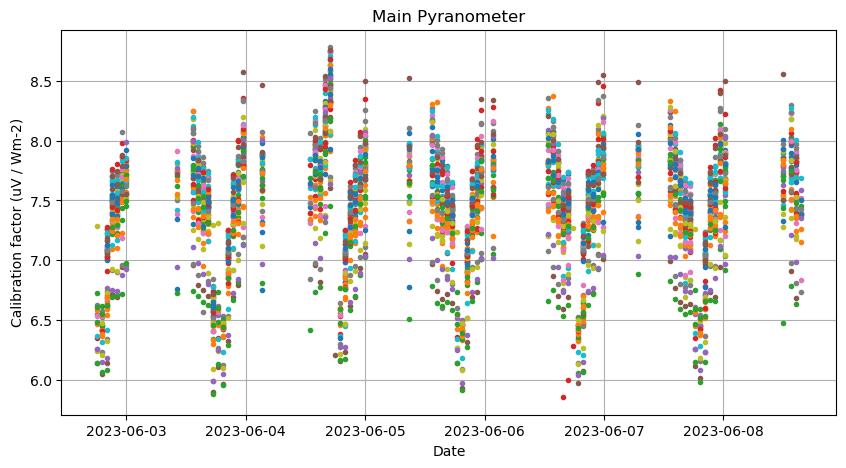

<Figure size 640x480 with 0 Axes>

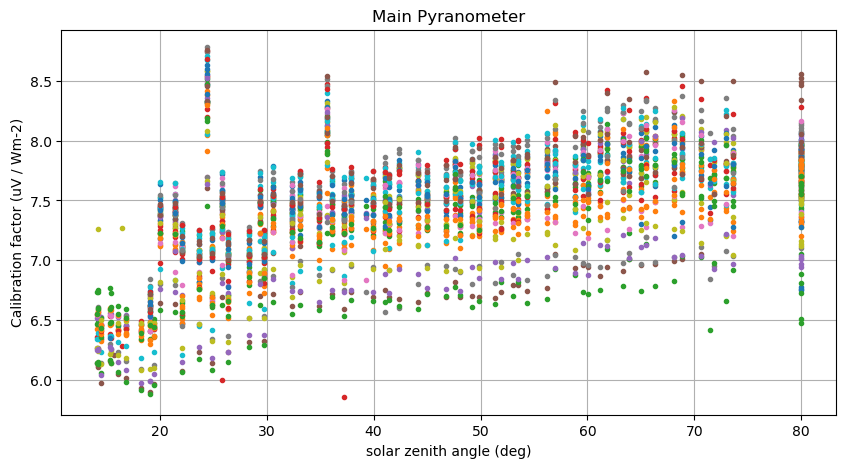

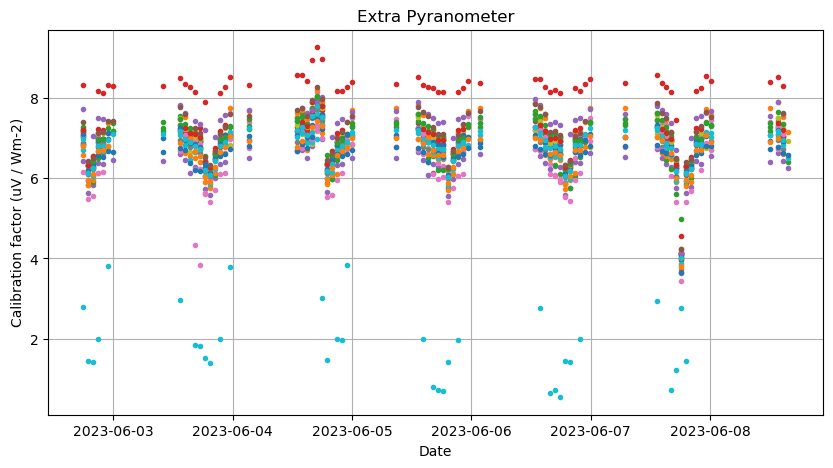

<Figure size 640x480 with 0 Axes>

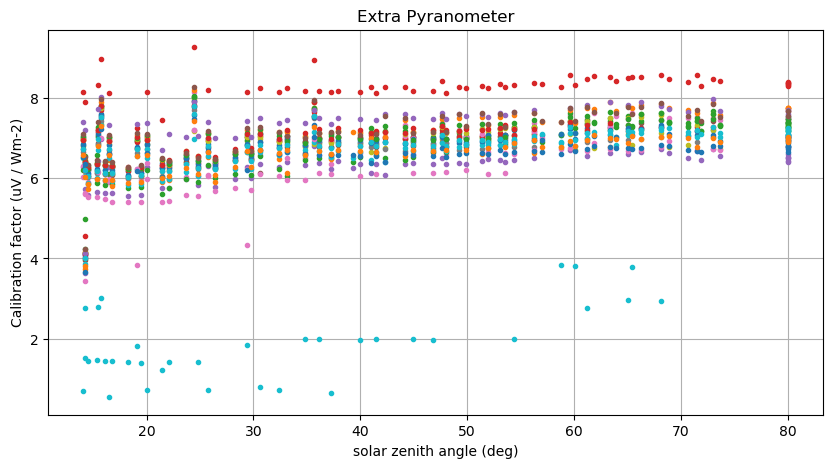

In [11]:
#|dropcode
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Main Pyranometer")
ax.plot(C_main.time, C_main, ls ="", marker='.')
ax.set_xlabel("Date")
ax.set_ylabel("Calibration factor (uV / Wm-2)")
ax.grid(True)
fig.show()

plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Main Pyranometer")
ax.plot(pyr.szen.interp_like(C_main), C_main, ls ="", marker='.')
ax.set_xlabel("solar zenith angle (deg)")
ax.set_ylabel("Calibration factor (uV / Wm-2)")
ax.grid(True)
fig.show()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Extra Pyranometer")
ax.plot(C_extra.time, C_extra, ls ="", marker='.')
ax.set_xlabel("Date")
ax.set_ylabel("Calibration factor (uV / Wm-2)")
ax.grid(True)
fig.show()

plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Extra Pyranometer")
ax.plot(pyr.szen.interp_like(C_extra), C_extra, ls ="", marker='.')
ax.set_xlabel("solar zenith angle (deg)")
ax.set_ylabel("Calibration factor (uV / Wm-2)")
ax.grid(True)
fig.show()


In [28]:
calibration_new = {}
print(f"Box:    Main       ,     Extra  ")
for box in C_main_mean.station:
    Cm = C_main_mean.sel(station=box).values
    Ce = C_extra_mean.sel(station=box).values
    Um = C_main_std.sel(station=box).values
    Ue = C_extra_std.sel(station=box).values
    
    calibration_new.update({
        f"{box:03d}": [float(Cm), float(Ce)]
    })
    print(f"{box:3d}: {Cm:.2f} +- {Um:.3f} , {Ce:.2f} +- {Ue:.3f}")

calibjson = {"2023-06-02": calibration_new}
with open("pyrnet_calib_2023-06_s2vsr.json","w") as txt:
    json.dump(calibjson, txt)

Box:    Main       ,     Extra  
  1: 7.64 +- 0.360 , 6.88 +- 0.481
  2: 7.56 +- 0.322 , nan +- nan
  3: 7.69 +- 0.282 , nan +- nan
  4: 7.43 +- 0.728 , 8.25 +- 0.553
  5: 7.57 +- 0.321 , 6.27 +- 0.469
  6: 6.62 +- 0.374 , nan +- nan
  7: 7.63 +- 0.341 , 6.73 +- 0.865
  8: 7.87 +- 0.355 , nan +- nan
  9: 7.62 +- 0.327 , 6.73 +- 0.476
 10: 7.73 +- 0.357 , 2.14 +- 1.451
 12: 7.68 +- 0.322 , 6.71 +- 0.523
 13: 7.08 +- 0.409 , nan +- nan
 15: 7.63 +- 0.316 , 6.77 +- 0.651
 16: 7.42 +- 0.038 , nan +- nan
 17: 7.43 +- 0.456 , nan +- nan
 18: 7.63 +- 0.403 , 6.74 +- 0.579
 19: 7.55 +- 0.041 , nan +- nan
 20: 7.37 +- 0.505 , nan +- nan
 21: 7.66 +- 0.360 , nan +- nan
 22: 7.17 +- 0.570 , nan +- nan
 23: 7.41 +- 0.026 , nan +- nan
 24: 7.71 +- 0.429 , 6.30 +- 0.556
 25: 7.36 +- 0.445 , 7.03 +- 0.492
 26: 7.64 +- 0.366 , 6.88 +- 0.523
 28: 7.56 +- 0.031 , nan +- nan
 29: 7.41 +- 0.036 , nan +- nan
 32: 7.79 +- 0.328 , 6.83 +- 0.459
 33: 7.84 +- 0.356 , 6.64 +- 0.504
 35: 7.71 +- 0.384 , 6.98 +- 

In [27]:
#|hide
import nbformat as nbf
name = "calibration_s2vsr"
# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)
# ntbk = jupytext.read(f"{name}.ipynb")
text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
nbf.write(ntbk, f"../../docs/source/calibration/{name}.ipynb")